<a id=1></a>    

<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#588157;
            overflow:hidden;
            font-weight:500">
        1. Abstract
</div>

[go on top](#0)
<br>[go next chapter ↓](#2)

This notebook focuses on exploring ways to create recommender systems, mainly content and collaboratively based.
The dataset consisted of more than 70 thousand interactions on 3000 articles by 3000 users.
It achieves a RMSE score of 0.62 and MAE of 0.46 on test data.

<a id=2></a>    

<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#706677;
            overflow:hidden;
            font-weight:500">
        2. Imports
</div>

[go on top](#0)
<br>[go previous chapter ↑](#1)
<br>[go next chapter ↓](#3)

In [40]:
# Data manipulations
import pandas as pd
import numpy as np

# Data Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# For multiple pretty-prints of dataframes from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# ignore warnings to clean up output cells
from warnings import simplefilter
simplefilter("ignore")

# Tools for building recommenders
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

# For collaborative filtering
from surprise import SVD, Dataset, Reader, SVDpp
from surprise.model_selection import cross_validate, KFold

<a id=3></a> 

<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#6a994e;
            overflow:hidden;
            font-weight:500">
       3. Exploratory Data Analysis
</div>   

[go on top](#0)
<br>[go previous chapter ↑](#2)
<br>[go next chapter ↓](#4)

### **About the dataset:**

Deskdrop is an internal communications platform developed by CI&T, focused in companies using Google G Suite. Among other features, this platform allows companies employees to share relevant articles with their peers, and collaborate around them.

This dataset contains a real sample of 12 months logs (Mar. 2016 - Feb. 2017) from CI&T's Internal Communication platform (DeskDrop).
I contains about 73k logged users interactions on more than 3k public articles shared in the platform.

This dataset features some distinctive characteristics:
- **Item attributes:** Articles' original URL, title, and content plain text are available in two languages (English and Portuguese).
- **Contextual information:** Context of the users visits, like date/time, client (mobile native app / browser) and geolocation.
- **Logged users:** All users are required to login in the platform, providing a long-term tracking of users preferences (not depending on cookies in devices).
- **Rich implicit feedback:** Different interaction types were logged, making it possible to infer the user's level of interest in the articles (eg. comments > likes > views).
- **Multi-platform:** Users interactions were tracked in different platforms (web browsers and mobile native apps)

___

### **Articles file EDA:**

In [2]:
# Read data
articles = pd.read_csv("./data/shared_articles.csv", parse_dates=["timestamp"])

# Print first 5 rows 
print("\nArticles dataframe:")
articles.head()


Articles dataframe:


,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


___

Timestamp is in *unix* format. Lets change it to datetime

In [3]:
articles["timestamp"] = pd.to_datetime(articles["timestamp"], unit="s")
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,2016-03-28 19:19:39,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,2016-03-28 19:39:48,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,2016-03-28 19:42:26,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,2016-03-28 19:47:54,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,2016-03-28 19:48:17,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


___

In [6]:
# View number of unique values:
t = []
for col in articles.columns:
    t.append([col, pd.notna(articles[col]).sum(), len(articles[col].unique())])
t = pd.DataFrame(t, columns=["Column", "Not-NaN values", "Unique values"])
t["Dtype"] = list(articles.dtypes)
t

,Column,Not-NaN values,Unique values,Dtype
0,timestamp,3122,3121,datetime64[ns]
1,eventType,3122,2,object
2,contentId,3122,3057,int64
3,authorPersonId,3122,252,int64
4,authorSessionId,3122,2017,int64
5,authorUserAgent,680,115,object
6,authorRegion,680,20,object
7,authorCountry,680,6,object
8,contentType,3122,3,object
9,url,3122,3029,object


___

<BarContainer object of 5 artists>

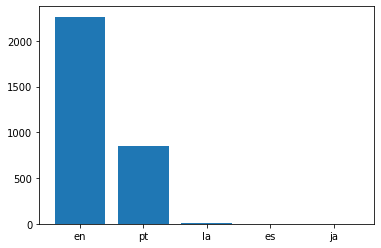

In [7]:
# Articles language
plt.bar(articles["lang"].value_counts().index, articles["lang"].value_counts())

___


Missing values in interactions dataframe:


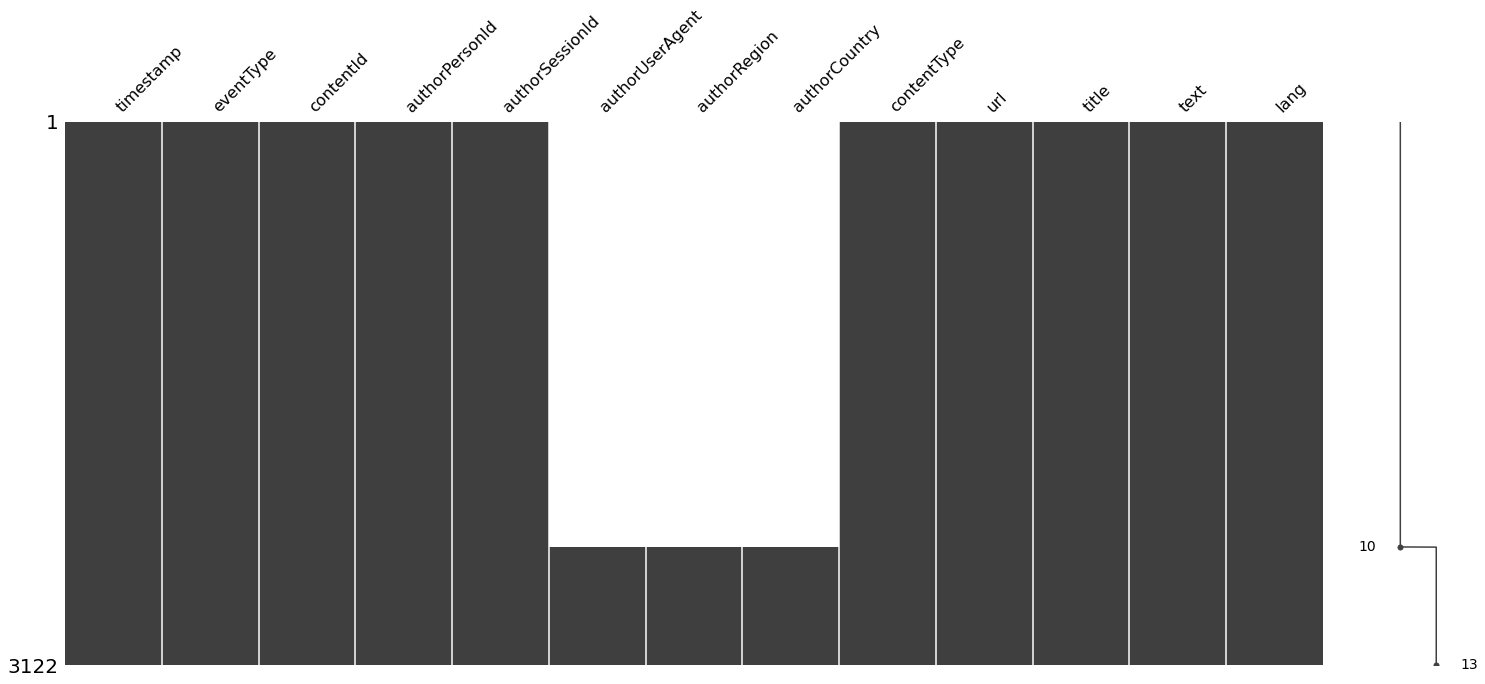

In [8]:
# View missing values in the dataframe
print("\nMissing values in interactions dataframe:")
fig = msno.matrix(articles)
plt.show()

___

In [9]:
# Average length of title
title_words = articles["title"].str.count(" ") + 1
print(f"There are around {title_words.mean():.0f} words in each title")

There are around 9 words in each title


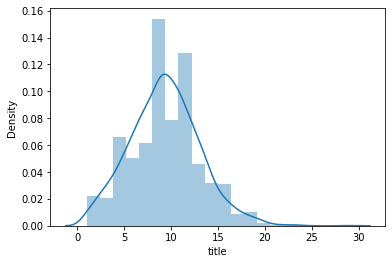

In [10]:
# Title length in words
fig = sns.distplot(title_words, bins=20)

___

In [11]:
# Average length of text
text_words = articles["text"].str.count(" ") + 1
print(f"There are around {text_words.mean():.0f} words in each article")

There are around 899 words in each article


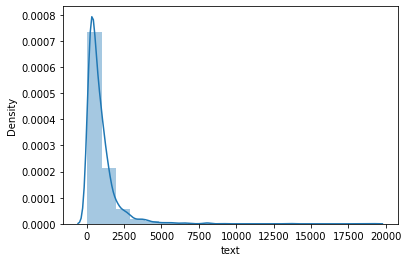

In [12]:
# Title length in words
fig = sns.distplot(text_words, bins=20)

___

View correlation between title length and article length:


,title words,text words
title words,1.00000,-0.09859
text words,-0.09859,1.00000


Heatmap:


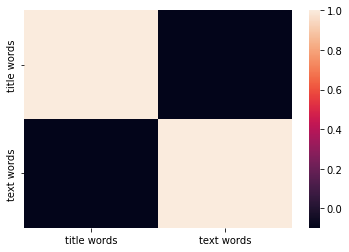

In [13]:
# View correlation between title length and article length
df = pd.concat([title_words, text_words], ignore_index=True, axis=1)
df.columns = ["title words", "text words"]
print("View correlation between title length and article length:")
df.corr(method="pearson")
print("Heatmap:")
fig = sns.heatmap(df.corr(method="pearson"))

There is no significant correlation between title and article length.

___

In [14]:
# Number of records in dataframe:
print(f"There are {len(articles)} records in this dataframe.")

There are 3122 records in this dataframe.


___

Text(0.5, 1.0, 'Authors by country')

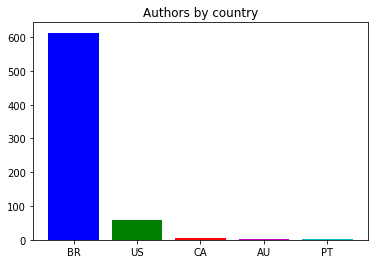

In [15]:
# View authors by country
data = articles["authorCountry"].value_counts()
fig = plt.bar(x = data.index, 
              height = data,
              color=["b", "g", "r", "m", "c"])
plt.title("Authors by country")
plt.show()

___

In [16]:
print("Authors by region")
articles["authorRegion"].value_counts()

Authors by region


SP     533
MG      75
NY      20
NJ      16
GA       7
IL       6
ON       4
RJ       4
NSW      2
TX       2
?        2
SC       2
RI       1
AB       1
FL       1
13       1
WA       1
CA       1
MS       1
Name: authorRegion, dtype: int64

___

In [17]:
# View event types
print("Event types:")
articles["eventType"].value_counts()

Event types:


CONTENT SHARED     3047
CONTENT REMOVED      75
Name: eventType, dtype: int64

___

In [18]:
# View articles content type
print("Articles content type:")
articles["contentType"].value_counts()

Articles content type:


HTML     3101
VIDEO      11
RICH       10
Name: contentType, dtype: int64

### **Interactions file EDA:**

In [19]:
interactions = pd.read_csv("./data/users_interactions.csv")

print("\nInteractions dataframe:")
interactions.head()


Interactions dataframe:


,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN



Missing values in interactions dataframe:


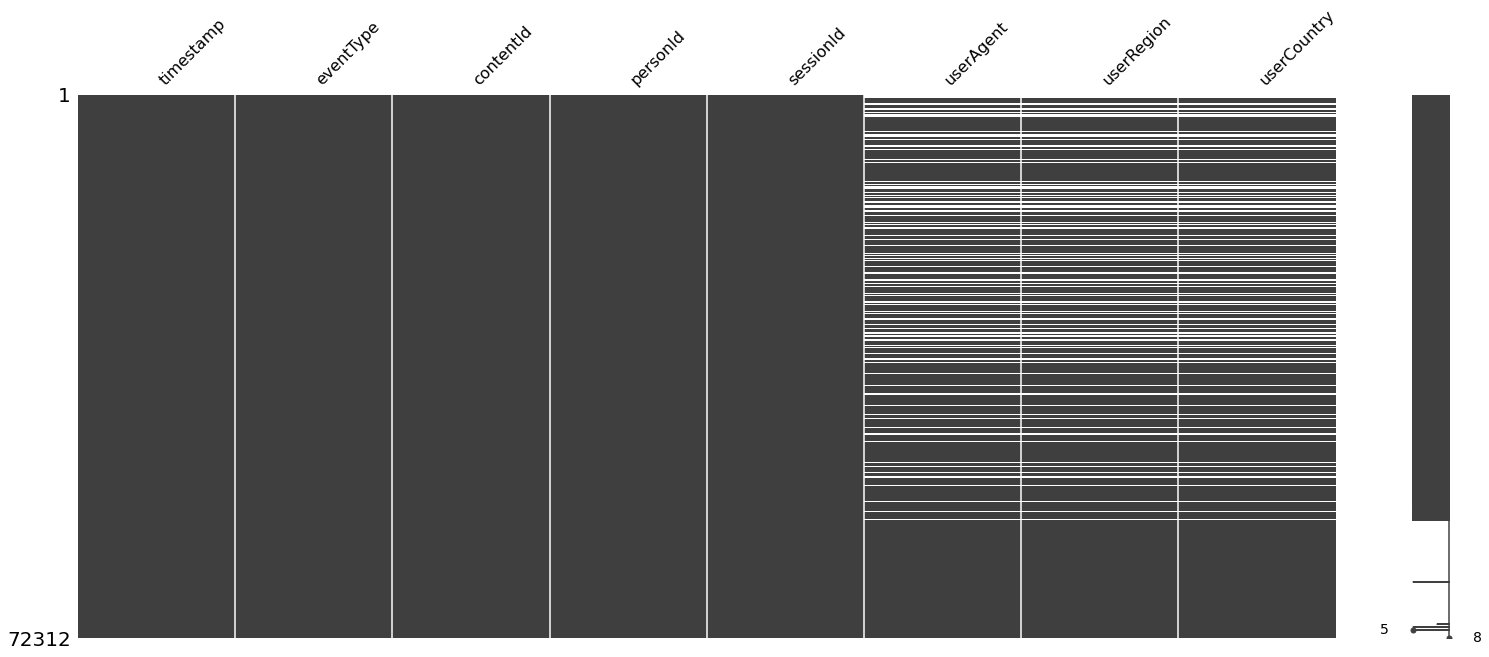

In [20]:
# View missing values in the dataframe
print("\nMissing values in interactions dataframe:")
fig = msno.matrix(interactions)
plt.show()

In [21]:
# View number of unique values:
t = []
for col in interactions.columns:
    t.append([col, pd.notna(interactions[col]).sum(), len(interactions[col].unique())])
t = pd.DataFrame(t, columns=["Column", "Not-NaN values", "Unique values"])
t["Dtype"] = list(interactions.dtypes)
t

,Column,Not-NaN values,Unique values,Dtype
0,timestamp,72312,68772,int64
1,eventType,72312,5,object
2,contentId,72312,2987,int64
3,personId,72312,1895,int64
4,sessionId,72312,28740,int64
5,userAgent,56918,1091,object
6,userRegion,56907,72,object
7,userCountry,56918,24,object


 Note there are 1895 unique *personId*

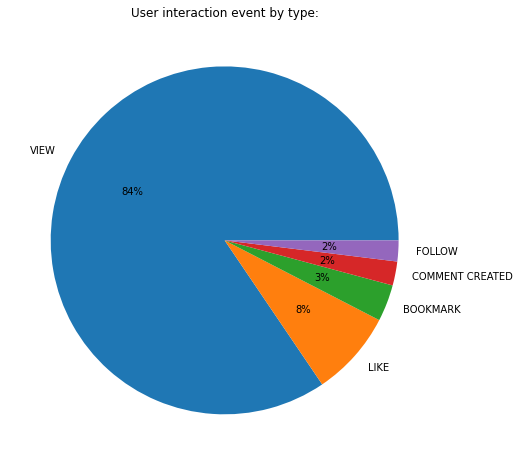

In [22]:
data = interactions["eventType"].value_counts()
labels = data.index

fig = plt.subplots(figsize=(8,8))
fig = plt.pie(data, 
              labels=labels, 
              
              autopct='%.0f%%')
fig = plt.title("User interaction event by type:")
plt.show()

In [23]:
# View user regions
print("Users by region:")
interactions["userRegion"].value_counts()

Users by region:


SP    40164
MG    10229
NY     1257
TX      923
GA      910
      ...  
R         1
CE        1
NH        1
MN        1
CL        1
Name: userRegion, Length: 71, dtype: int64

In [24]:
# View user country
print("Users by country:")
interactions["userCountry"].value_counts()

Users by country:


BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
ZZ       11
SG       11
AR        7
PT        6
ES        3
IN        3
MY        2
IT        2
CN        1
NL        1
CL        1
CO        1
CH        1
Name: userCountry, dtype: int64

<a id=4></a>  

<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#5f0f40;
            overflow:hidden;
            font-weight:500">
       4. Data preprocessing
</div>  

[go on top](#0)
<br>[go previous chapter ↑](#3)
<br>[go next chapter ↓](#5)

Assign importnace to users interactions:

In [25]:
# Dictionary with relationship event-strength
event_type_strength = {
    "VIEW" : 1.0,
    "LIKE" : 2.0, 
    "COMMENT CREATED" : 2.0,
    "BOOKMARK" : 3.0,
    "FOLLOW"  : 4.0,
    }

# New column with event strength
interactions["Event_Strength"] = interactions["eventType"].apply(lambda x: event_type_strength[x])

# View 5 rows 
interactions[["Event_Strength", "eventType"]].head()

,Event_Strength,eventType
0,1.0,VIEW
1,1.0,VIEW
2,1.0,VIEW
3,4.0,FOLLOW
4,1.0,VIEW


Recommender systems are known for their cold-start problem which comes from the dificultly to make recommendations to new users. To avoid this I will select only the users who have at least 5 interactions.

In [26]:
# DataFrame that counts number of interactions per user
user_interactions_count_df = interactions.groupby(["personId", "contentId"]).size() \
                                         .groupby("personId").size()
print(f"Number of users: {len(user_interactions_count_df)}")

# DataFrame that contains users with at least 5 interactions
users_with_enough_interactions = user_interactions_count_df[
                                    user_interactions_count_df>=5].reset_index()[["personId"]]
print(f"Number of users with at least 5 interactions: {len(users_with_enough_interactions)}")

Number of users: 1895
Number of users with at least 5 interactions: 1140


<br>Select interactions of users with at least 5 interactions:

In [31]:
print(f"Total number of interactions: {len(interactions)}")
interactions_selected_users = interactions.merge(users_with_enough_interactions,
                                                 how="right",
                                                 left_on="personId",
                                                 right_on="personId")

print("Total number of interactions of users with at least "+
      f"5 interactions: {len(interactions_selected_users)}")

Total number of interactions: 72312
Total number of interactions of users with at least 5 interactions: 69868


<br> Users are allowed to make multiple interactions with articles (e.g. view), thus I will add all interactions and will log-transform to smooth the distribution

In [32]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = interactions_selected_users \
                        .groupby(["personId", "contentId"])["Event_Strength"].sum() \
                        .apply(smooth_user_preference).reset_index()

interactions_full_df.head()

,personId,contentId,Event_Strength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


<a id=5></a>    

<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#489fb5;
            overflow:hidden;
            font-weight:500">
       5. Content-based filtering
</div>

[go on top](#0)
<br>[go previous chapter ↑](#4)
<br>[go next chapter ↓](#6)

In [37]:
"""
Compute TF_IDF - Term Frequency-Inverse Document Frequency 
TF = term instances/total instances
IDF = log(number of documents/documents with term)
TF_IDF = TF * IDF
"""

tfidf_articles = tfidf(stop_words="english").fit_transform(articles["text"])

'\nCompute TF_IDF - Term Frequency-Inverse Document Frequency \nTF = term instances/total instances\nIDF = log(number of documents/documents with term)\nTF_IDF = TF * IDF\n'

$72353$ different words describe $3122$ articles in our dataset.

In [34]:
# Compute cosine similarity between articles
cosine_articles = cosine_similarity(tfidf_articles, tfidf_articles)

In [ ]:
# Create a reverse mapping between article ID and article indice in the dataframe
indice_mapping = pd.Series(articles.index, index=articles["contentId"])
indice_mapping.head()

contentId
-6451309518266745024    0
-4110354420726924665    1
-7292285110016212249    2
-6151852268067518688    3
 2448026894306402386    4
dtype: int64

In [ ]:
# Function that takes in contentId and returns 10 most similar articles:
def get_similar(content_id, m=10, cosine_matrix=cosine_articles):
    # Get the indice of article that matches the content ID
    idx = indice_mapping[content_id]
    
    # Get similarity scores for the specified article
    similarity_scores = list(enumerate(cosine_articles[idx]))
    
    # Sort scores
    similarity_scores = sorted(similarity_scores,
                               key=lambda x: x[1],
                               reverse=True)
    
    # Pick 10 articles with highest similarity:
    n = 0  # Number of recommended articles
    i = 1  # Iterator through articles with most similarity
    recommended = [] # List for storing recommended articles
    while n<m:
        # Dont recommend articles that were removed
        if any((articles[articles["contentId"]==articles.iloc[i]["contentId"]].eventType=="CONTENT REMOVED")):
            i += 1
            continue
        recommended.append(articles.iloc[similarity_scores[i][0]])
        n += 1
        i += 1
      
    return pd.DataFrame(recommended)

In [ ]:
# View some random recommandations
print(f"Article on which the recommendations are based: \n{articles.loc[3].title} ")
print("\nRecommended articles:")
recommended = get_similar(articles.loc[3].contentId, m=10)    
recommended[["timestamp", "title"]]

Article on which the recommendations are based: 
Google Data Center 360° Tour 

Recommended articles:


,timestamp,title
142,2016-04-01 14:24:29,Google shares data center security and design ...
676,2016-04-29 14:24:18,This year's Founders' Letter
248,2016-04-07 10:20:23,Google Cloud Platform: The smart person's guid...
906,2016-05-12 12:10:07,YouTube's New Messenger Means You'll Never Hav...
547,2016-04-22 16:54:20,Top 5 GCP NEXT breakout sessions on YouTube (s...
884,2016-05-10 22:09:16,Google I/O 2016 Preview: A Chrome/Android merg...
958,2016-05-13 20:23:06,"Google I/O 2016 preview: Android N, Android VR..."
2885,2016-12-17 12:21:21,[Tools] How to Record your Desktop Screen with...
962,2016-05-13 22:46:21,"Google I/O 2016 Preview: Machine Learning, Vir..."
79,2016-03-30 18:07:07,Google admits original enterprise cloud strate...


In [ ]:
# View some random recommandations
print(f"Article on which the recommendations are based: \n{articles.loc[30].title} ")
print("\nRecommended articles:")
recommended = get_similar(articles.loc[10].contentId, m=10)    
recommended[["timestamp", "title"]]

Article on which the recommendations are based: 
Indústria 4.0: desafios e oportunidades 

Recommended articles:


,timestamp,title
2487,2016-09-30 20:06:55,Negociação deve garantir ocupação de shoppings...
1807,2016-07-18 03:56:43,Como o Pokémon Go ajuda a explicar por que o B...
1110,2016-05-25 23:45:41,"Como o e-commerce brasileiro pode, enfim, come..."
2882,2016-12-16 12:30:36,"SINAIS do FUTURO imediato: #1, internet das co..."
2571,2016-10-17 12:45:42,A saga do jovem CEO da Dasa
2763,2016-11-18 13:50:44,Black Friday salva o ano do e-commerce
2152,2016-08-23 04:36:47,Degraus para o sucesso: a inovação no core do ...
2754,2016-11-16 13:19:47,Saiba como a Cisco está trabalhando com IoT e ...
2684,2016-10-31 09:34:02,"Por dentro do Nubank, conheça os segredos da f..."
1191,2016-06-01 19:04:18,Por que o Walmart não é Walmart no Brasil


____

## CONTENT BASED RECOMMENDATIONS OF ARTICLES FROM LAST WEEK

In [ ]:
# Function that takes in contentId and returns 10 most similar articles from last 5 days:
def get_similar_last_week(content_id, m=10, cosine_matrix=cosine_articles):
    # Get the indice of article that matches the content ID
    idx = indice_mapping[content_id]
    
    # Get similarity scores for the specified article
    similarity_scores = list(enumerate(cosine_articles[idx]))
    
    # Sort scores
    similarity_scores = sorted(similarity_scores,
                               key=lambda x: x[1],
                               reverse=True)

    # Pick 10 articles with highest similarity:
    n = 0  # Number of recommended articles
    i = 0  # Iterator through articles with most similarity
    recommended = [] # List for storing recommended articles
    
    date_article = articles[articles.contentId == content_id].iloc[0].timestamp 

    while (n<m) and (i<len(articles)-1):
        i += 1
        
        # Dont recommend articles that were removed
        if any((articles[articles["contentId"]==articles.iloc[i]["contentId"]].eventType=="CONTENT REMOVED")):
            continue
            
        # Timestamp of similar article
        date_similar = articles.iloc[similarity_scores[i][0]].timestamp
        
        # Delta between dates
        delta = (date_article - date_similar).days 
    
        # Recommend only articles that are most similar and were published last 5 days 
        if 0 < delta < 5:
            recommended.append(articles.iloc[similarity_scores[i][0]])
            n += 1
            
    return pd.DataFrame(recommended)

In [ ]:
# View some random recommandations
print(f"Article on which the recommendations are based:")
print(articles.loc[2000][["timestamp", "title"]])
print("\nRecommended articles:")
recommended = get_similar_last_week(articles.loc[2000].contentId)    
recommended[["timestamp", "title"]]

Article on which the recommendations are based:
timestamp         2016-08-05 17:39:26
title        The Broken Window Theory
Name: 2000, dtype: object

Recommended articles:


,timestamp,title
1974,2016-08-03 17:15:09,10 Things I Gained When I Gave Up All My Stuff
1941,2016-07-31 17:50:36,New South & Central America Trend Briefing fro...
1975,2016-08-03 17:20:30,Most People Say They Could Get Rid of Tons of ...
1970,2016-08-03 12:15:10,AI Revolution 101 - AI Revolution
1952,2016-08-01 18:28:15,5 Internet Trends to Pay Attention to in Late ...
1960,2016-08-02 18:18:19,Automation and anxiety
1958,2016-08-02 14:40:03,'Training for Google Apps' Is One Of Chrome's ...
1954,2016-08-01 18:58:55,10 Free Screen Readers For Blind Or Visually I...
1945,2016-08-01 11:41:18,You don't talk about refactoring club
1981,2016-08-04 16:52:48,This startup uses machine learning and satelli...


In [ ]:
# View some random recommandations
print(f"Article on which the recommendations are based:")
print(articles.loc[600][["timestamp", "title"]])
print("\nRecommended articles:")
recommended = get_similar_last_week(articles.loc[600].contentId)    
recommended[["timestamp", "title"]]

Article on which the recommendations are based:
timestamp                                  2016-04-26 19:16:19
title        Cinco competências comportamentais para você s...
Name: 600, dtype: object

Recommended articles:


,timestamp,title
538,2016-04-22 14:17:42,"E quando o cliente diz ""Não gostei""?"
582,2016-04-25 19:04:13,"diagramas para entender, criar, inovar e empre..."
529,2016-04-21 19:19:35,big data = real time
536,2016-04-22 13:53:11,Como os millennials estão mudando o mercado fi...
571,2016-04-25 14:12:33,Especial Agrishow: Soluções de agricultura de ...
531,2016-04-21 21:13:09,Modelando APIs REST com Swagger
575,2016-04-25 14:55:49,Clientes poderão abrir e fechar conta corrente...
576,2016-04-25 15:00:02,Clientes poderão abrir e fechar conta corrente...
530,2016-04-21 19:45:11,Documentando uma API JAX-RS com Swagger
532,2016-04-22 12:02:24,#188. Profissão: Gerente de Projetos by brains9


<a id=6></a>    

<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#00afb9;
            overflow:hidden;
            font-weight:500">
       6. Collaborative filtering
</div>

[go on top](#0)
<br>[go previous chapter ↑](#5)
<br>[go next chapter ↓](#7)

In [59]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(interactions_full_df[["personId", "contentId", "Event_Strength"]], reader)

history = cross_validate(SVD(), data, cv=5, measures=["rmse", "mae"])

In [61]:
print(f"Mean RMSE on test data: {np.mean(history['test_rmse']):.2f}")
print(f"Mean MAE on test data: {np.mean(history['test_mae']):.2f}")

Mean RMSE on test data: 0.62
Mean MAE on test data: 0.46
